In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import wfdb

In [2]:
def parabola(a,n,r):
    assert n>2*r
    y = np.zeros(n, dtype = np.float32)
    x = np.array(range(2, 2 * r+1))
    for i in a:
        if i > r-1 and i <= n-r:
            # y[i-r-1:i+r+1] = ((r+1)**2-(x-r-1)**2)/(r+1)**2
            y[i-r+1:i+r] = ((r+1)**2-(x-r-1)**2)/(r+1)**2
        elif i < r:
            y[:i+r] = ((r+1)**2-(x[r-i-1:]-r-1)**2)/(r+1)**2
        elif i<n:
            y[i-r+1:] = ((r+1)**2-(x[:r-1+(n-i)]-r-1)**2)/(r+1)**2
    return y

In [3]:
def selectFromSignal(signal, seqL, ninputs, numChan=2):
    """ 
    seqL:  number of timesteps to be used in recurrent nn
    ninput : is number of inputs in each timestep
    """
    segmentL  = seqL * ninputs; print(segmentL)
    inpOutSegment = tf.random_crop(signal, [numChan, segmentL])
    inputs = inpOutSegment[0, :]
    target = inpOutSegment[1, :]
    return inputs, target

def selectFromSignals(signals, seqL, ninputs, numChan=3):
    file_idx = np.random.randint(0, signals.shape[0]) 
#     signal = signals[file_idx, :, :]
    
    segmentL  = seqL * ninputs
    inpOutSegment = tf.random_crop(signals[file_idx, :, :], [numChan, segmentL])
#   inpOutSegment = tf.random_crop(signals[file_idx, :, 100:], [numChan, segmentL])

    inputs = inpOutSegment[0:2, :]
    target = inpOutSegment[2, :]
    return inputs, target

((462600,), (462600,))

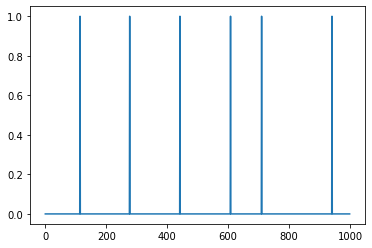

In [48]:
record = wfdb.rdrecord('train/I01', channels=[1, 6])
annotation = wfdb.rdann('train/I01', 'atr')

signals = record.__dict__['p_signal']
channel_ii = signals[:, 0]
channel_v1 = signals[:, 1]

ticks = annotation.__dict__['sample']
symbols = annotation.__dict__['symbol']

ticks_signal = np.zeros(channel_ii.shape)
ticks_signal[ticks] = 1.0
plt.plot(ticks_signal[:1000])

channel_ii.shape, channel_v1.shape

### Preprocessing functions

In [9]:
def removeBaseline(signal,fs):
    baseline = np.convolve(signal, np.ones(fs)/fs, mode = 'same')
    signalFinal = signal-baseline
    return signalFinal,baseline

def getTwoNormalizedChannels(signals, fs):
    
    # get channel II and V1
    channel_ii = signals[:, 0]
    channel_v1 = signals[:, 1]
    
    # remove baselines
    chii_data_filter, _ = removeBaseline(channel_ii, fs)
    chv1_data_filter, _ = removeBaseline(channel_v1, fs)
    
    # reshape to  -> (1, 462600)
    chii_data_filter = chii_data_filter.reshape((1, -1))
    chv1_data_filter = chv1_data_filter.reshape((1, -1))
    
    # put two signals together -> (2, 462600)
    signal = np.concatenate((chii_data_filter, chv1_data_filter), axis=0)
    
    return signal

### Parameters

In [44]:
window_size = 240
p_param = 10
seqL = 20
fs = 257
ninputs = int(0.05*fs) 
batchSize = 8
testDataSize = 62600
val_perc = 0.15

### Load Training data into all_data

In [13]:
record = wfdb.rdrecord('train/I01', channels=[1, 6])
annotation = wfdb.rdann('train/I01', 'atr')
signals = record.__dict__['p_signal']

N = signals.shape[0]
train_fs = record.__dict__['fs']
print(">>> Training data fs is {}\n".format(int(train_fs)))
p_param = 10

import os
filenames = np.unique(list(map(lambda x : x.split('.')[0], os.listdir('train'))))
qrsAnnot = ['N','L','R','B','A','a','J','S','V','r','F','e','j','n','E','/','f','Q',' ?']

all_data = np.zeros((len(filenames), signals.shape[1]+1, N), dtype=np.float32)
idx = 0

for f in filenames[:10]:
    path = 'train/{}'.format(f)
    # read annotation
    annotation = wfdb.rdann(path, 'atr')
    uniq_symbols = np.unique(annotation.__dict__['symbol'])
    
    # check if all symbols can be found in qrsAnnot list
    if not np.all([(symbol in qrsAnnot) for symbol in uniq_symbols]):
        print("! Skipping {}...".format(f))
        continue
    
    # read signals
    record = wfdb.rdrecord(path, channels=[1, 6])
    signals = record.__dict__['p_signal']
    signal = getTwoNormalizedChannels(signals, train_fs)

    # get ticks and create parabola
    ticks = annotation.__dict__['sample']
    if np.any(ticks < 0):
        print("! Negative ticks in ", f)
        ticks = ticks[1:]
    
    p = parabola(ticks, N, p_param)
    
    targets = p.reshape((1, -1))
    
    # create data with signals on data[0], data[1] and ticks on data[2]
    data = np.concatenate((signal, targets), axis=0)
    
    all_data[idx] = data
    idx += 1
    print("Loaded ", f)

all_data = all_data[:idx]
print("\nTraining data shape:", all_data.shape)

>>> Training data fs is 257

Loaded  I01
Loaded  I02
Loaded  I03
! Negative ticks in  I04
Loaded  I04
Loaded  I05
Loaded  I06
Loaded  I07
Loaded  I08
Loaded  I09
Loaded  I10

Training data shape: (10, 3, 462600)


### Load Test data into test_data

In [36]:
record = wfdb.rdrecord('test/100')
annotation = wfdb.rdann('test/100', 'atr')
signals = record.__dict__['p_signal']
test_fs = record.__dict__['fs']
print(">>> Test data fs is {}\n".format(int(test_fs)))

signals, annotation = wfdb.processing.resample_multichan(signals, annotation, 
                                                            test_fs, train_fs)
N = signals.shape[0]

p_param = 10

import os
filenames = np.unique(list(map(lambda x : x.split('.')[0], os.listdir('test'))))
qrsAnnot = ['N','L','R','B','A','a','J','S','V','r','F','e','j','n','E','/','f','Q',' ?']

test_data = np.zeros((len(filenames), signals.shape[1]+1, N), dtype=np.float32)
idx = 0

for f in filenames[:5]:
    path = 'test/{}'.format(f)
    # read annotation
    annotation = wfdb.rdann(path, 'atr')
    uniq_symbols = np.unique(annotation.__dict__['symbol'])
    
    # check if all symbols can be found in qrsAnnot list
    # ... skipped?
    
    # read signals
    record = wfdb.rdrecord(path)
    signals = record.__dict__['p_signal']
    
    # resample to train frequency!
    new_signals, new_annotation = wfdb.processing.resample_multichan(signals, annotation, 
                                                            test_fs, train_fs)
    
    signal = getTwoNormalizedChannels(new_signals, test_fs)
    # get ticks and create parabola
    ticks = new_annotation.__dict__['sample']

    if np.any(ticks < 0):
        print("! Negative ticks in ", f)
        ticks = ticks[1:]
    
    p = parabola(ticks, N, p_param)
    
    targets = p.reshape((1, -1))

    # create data with signals on data[0], data[1] and ticks on data[2]
    data = np.concatenate((signal, targets), axis=0)
    
    test_data[idx] = data
    idx += 1
    print("Loaded ", f)

test_data = test_data[:idx]
print("\nTest data shape: ", test_data.shape)

>>> Test data fs is 360

Loaded  100
Loaded  101
Loaded  102
Loaded  103
Loaded  104

Test data shape:  (5, 3, 464027)


### Preview of processed data

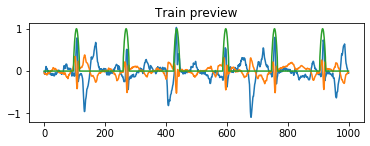

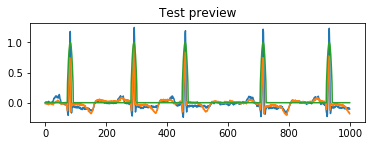

In [41]:
train_sample = all_data[0, :, 1000:2000]
x = np.arange(1000)

plt.figure(1)
plt.subplot(211)

plt.plot(x, train_sample[0, :], x, train_sample[1, :], x, train_sample[2, :])
plt.title("Train preview")
plt.show()

test_sample = test_data[0, :, 1000:2000]

plt.subplot(212)

plt.plot(x, test_sample[0, :], x, test_sample[1, :], x, test_sample[2, :])
plt.title("Test preview")
plt.show()

### Prepare Datasets for feed forward neural network

In [46]:
trainData = all_data
testData = test_data

# train validation split
valData = trainData[:, :, :int(trainData.shape[2]*val_perc)]
trainData = trainData[:, :, int(trainData.shape[2]*val_perc):]

print(trainData.shape, valData.shape, testData.shape)

# training data
trainData = tf.data.Dataset.from_tensors(trainData)
trainData = trainData.map(lambda x:  selectFromSignals(x, seqL, ninputs))
trainData = trainData.repeat()  # Repeat the input indefinitely.
trainData = trainData.batch(batchSize)

# validation data
valData = tf.data.Dataset.from_tensors(valData)
valData = valData.map(lambda x:  selectFromSignals(x, seqL, ninputs))
valData = valData.repeat()  # Repeat the input indefinitely.
valData = valData.batch(batchSize)

# test data
testData = tf.data.Dataset.from_tensors(testData)
testData = testData.map(lambda x:  selectFromSignals(x, seqL, ninputs))
testData = testData.repeat()  # Repeat the input indefinitely.
testData = testData.batch(batchSize)


(10, 3, 393210) (10, 3, 69390) (5, 3, 464027)


### Train data samples preview

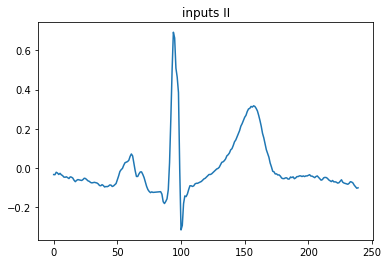

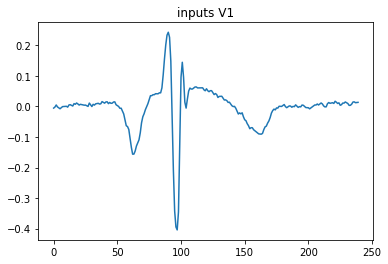

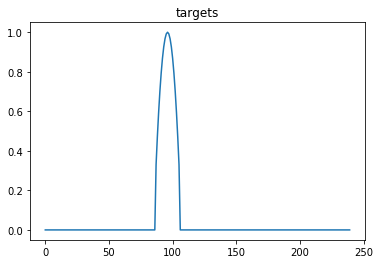

In [47]:
# let's visualize the model's input data and target data
iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
    
plt.plot(inp[0,0,:])
plt.title('inputs II')
plt.show()
plt.plot(inp[0,1,:])
plt.title('inputs V1')
plt.show()
plt.plot(targ[0,:])
plt.title('targets')
plt.show()

### Build and train feed forward model

In [48]:
from tensorflow.python.keras import layers

ffwdModel = tf.keras.Sequential()
ffwdModel.add(layers.Dense(64, activation='relu', input_shape=(2,seqL*ninputs)))
ffwdModel.add(layers.Dense(64, activation='relu'))
ffwdModel.add(layers.Flatten())
ffwdModel.add(layers.Dense(seqL * ninputs))
ffwdModel.summary()

ffwdModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
ffwdModel.fit(trainData, epochs=5, steps_per_epoch=1000, validation_data=valData, validation_steps=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2, 64)             15424     
_________________________________________________________________
dense_1 (Dense)              (None, 2, 64)             4160      
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 240)               30960     
Total params: 50,544
Trainable params: 50,544
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1000/1000 [==============================] - 18s 18ms/step - loss: 0.0395 - mean_absolute_error: 0.1156 - val_loss: 0.0868 - val_mean_absolute_error: 0.2084
Epoch 2

### Evaluate on the test set and preview sample prediction

500/500 [==============================] - 6s 13ms/step - loss: 0.4483 - mean_absolute_error: 0.4802
test mean square error (loss):  0.4482790265083313   test absolute error:  0.4801511


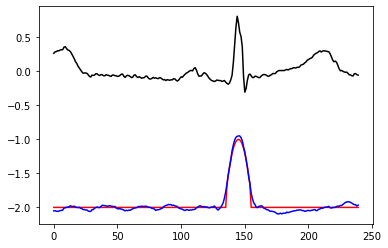

In [49]:
out = ffwdModel.evaluate(testData, steps=500)
print('test mean square error (loss): ', out[0], '  test absolute error: ', out[1])
iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
output = ffwdModel.predict(inp)
t = range(seqL*ninputs)
plt.plot(t,inp[0,0,:],'k',t,targ[0]-2,'r',t,output[0]-2,'b')
plt.show()

In [90]:
firstFile = test_data[0, :, :]

# test data
testData = tf.data.Dataset.from_tensors(firstFile)
testData = testData.map(lambda x:  selectFromSignal(x, seqL, ninputs))
testData = testData.repeat()  # Repeat the input indefinitely.
testData = testData.batch(batchSize)

out = ffwdModel.predict(testData, steps=1)
out.shape

240


ValueError: Error when checking input: expected dense_input to have 3 dimensions, but got array with shape (None, 240)

In [103]:
arr = [i for i in range(1, 25)]
arr = np.asarray(arr, dtype=np.uint16)
arr = arr.reshape(2, -1)

print(arr)

arr = arr.T
# print(arr)

arr = arr.reshape(3, 4, 2)
print(arr)

# arr = arr.reshape(3, -1)
# arr = arr.T

print(arr)

[[ 1  2  3  4  5  6  7  8  9 10 11 12]
 [13 14 15 16 17 18 19 20 21 22 23 24]]
[[[ 1 13]
  [ 2 14]
  [ 3 15]
  [ 4 16]]

 [[ 5 17]
  [ 6 18]
  [ 7 19]
  [ 8 20]]

 [[ 9 21]
  [10 22]
  [11 23]
  [12 24]]]
[[[ 1 13]
  [ 2 14]
  [ 3 15]
  [ 4 16]]

 [[ 5 17]
  [ 6 18]
  [ 7 19]
  [ 8 20]]

 [[ 9 21]
  [10 22]
  [11 23]
  [12 24]]]


In [67]:
numLstmUnits = 32
denseDim = ninputs
ffwdModelSequential = tf.keras.Sequential()

ffwdModelSequential.add(layers.Reshape((seqL,ninputs), input_shape=(seqL*ninputs,)))

ffwdModelSequential.add(layers.LSTM(units=numLstmUnits, return_sequences=True))         
ffwdModelSequential.add(layers.LSTM(units=numLstmUnits, return_sequences=True))
ffwdModelSequential.add(layers.TimeDistributed(layers.Dense(denseDim)))

ffwdModelSequential.add(layers.Reshape((seqL*ninputs,)))

ffwdModelSequential.summary()

ffwdModelSequential.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
ffwdModelSequential.fit(trainData,  epochs=10, steps_per_epoch=1000, validation_data=valData, validation_steps=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 20, 12)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 20, 32)            5760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 32)            8320      
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 12)            396       
_________________________________________________________________
reshape_1 (Reshape)          (None, 240)               0         
Total params: 14,476
Trainable params: 14,476
Non-trainable params: 0
_________________________________________________________________


ValueError: Error when checking input: expected reshape_input to have 2 dimensions, but got array with shape (None, 2, 240)

500/500 [==============================] - 18s 35ms/step - loss: 0.0091 - mean_absolute_error: 0.0454
test mean square error (loss):  0.009085805913899094   test absolute error:  0.045415346


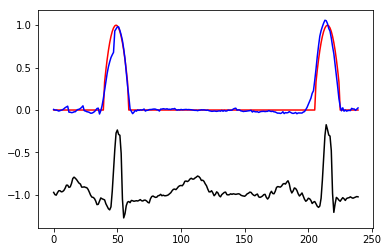

In [26]:
ffwdModelSequential.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
out = ffwdModelSequential.evaluate(testData, steps=500)
print('test mean square error (loss): ', out[0], '  test absolute error: ', out[1])
iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
output = ffwdModelSequential.predict(inp)
t = range(seqL*ninputs)
plt.plot(t,inp[0,:],'k',t,targ[0],'r',t,output[0],'b')
plt.show()

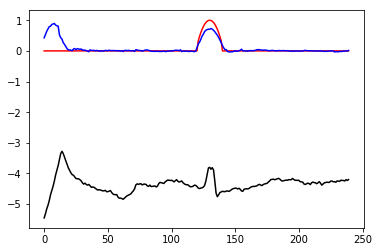

In [25]:
t = range(seqL*ninputs)
plt.plot(t,inp[0,:],'k',t,targ[0],'r',t,output[0],'b')
plt.show()